In [1]:
import os
import sys

import numpy as np
import pandas as pd
from tqdm import tqdm
import umap

from sklearn.metrics import jaccard_score

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

sys.path.append('./')
sys.path.append('../')
sys.path.append('../src')

from models import VAE
from datasets import InteractionDataset

import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR = '/Users/lindseyguan/Documents/zhang/PCSM-VAE/data'
MODEL_DIR = '/Users/lindseyguan/Documents/zhang/PCSM-VAE/models'

In [2]:
protein_dict = {0:'hp1a',
                1:'med1',
                2:'npm1'}

## Plotting 2-dimensional latent space by protein

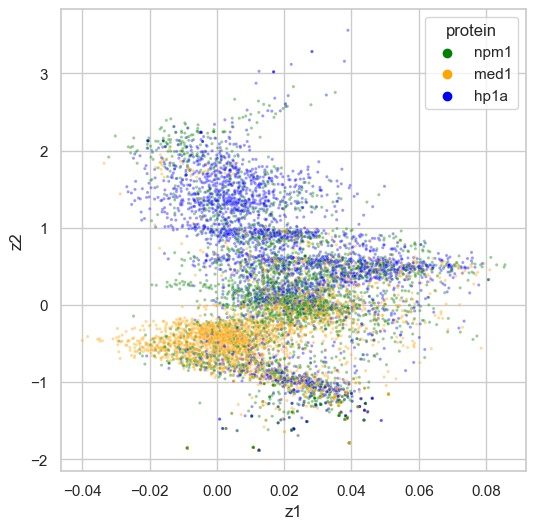

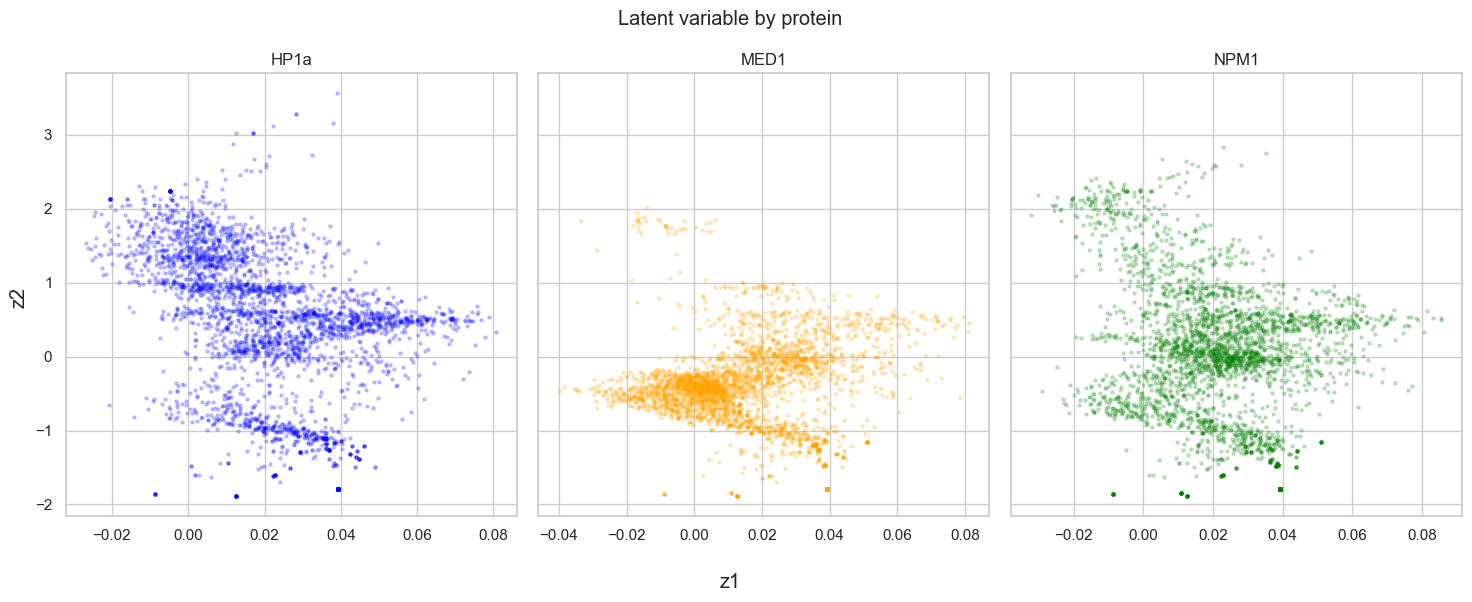

In [3]:
df = pd.read_pickle(os.path.join(MODEL_DIR, 'hidden_representation.pkl'))
df = df.rename(columns={0:'protein'})
df['protein'] = df['protein'].replace(protein_dict)
df[['z1', 'z2']] = pd.DataFrame(df['z'].tolist())

sns.set(rc={'figure.figsize':(6,6)})
sns.set_style("whitegrid")
sns.scatterplot(data=df, x="z1", y="z2", hue="protein", palette=['green', 'orange', 'blue'], s=5, alpha=0.4)
plt.savefig('latent_all.png', dpi=300)
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
fig.suptitle('Latent variable by protein')
fig.supxlabel('z1')
fig.supylabel('z2')

df_plot = df[df['protein'] == 'hp1a']
axes[0].scatter(x=df_plot['z1'], y=df_plot['z2'], s=5, alpha=0.2, color='blue')
axes[0].set_title('HP1a')

df_plot = df[df['protein'] == 'med1']
axes[1].scatter(x=df_plot['z1'], y=df_plot['z2'], s=5, alpha=0.2, color='orange')
axes[1].set_title('MED1')

df_plot = df[df['protein'] == 'npm1']
axes[2].scatter(x=df_plot['z1'], y=df_plot['z2'], s=5, alpha=0.2, color='green')
axes[2].set_title('NPM1')

plt.tight_layout()
plt.savefig('latent_sep.png', dpi=300)
plt.show()

## Visualizing 16-dimensional latent space combined with UMAP

From a VAE trained on combined MED1+HP1A+NPM1 data (sampling 700 datapoints because otherwise I get memory errors on my machine).

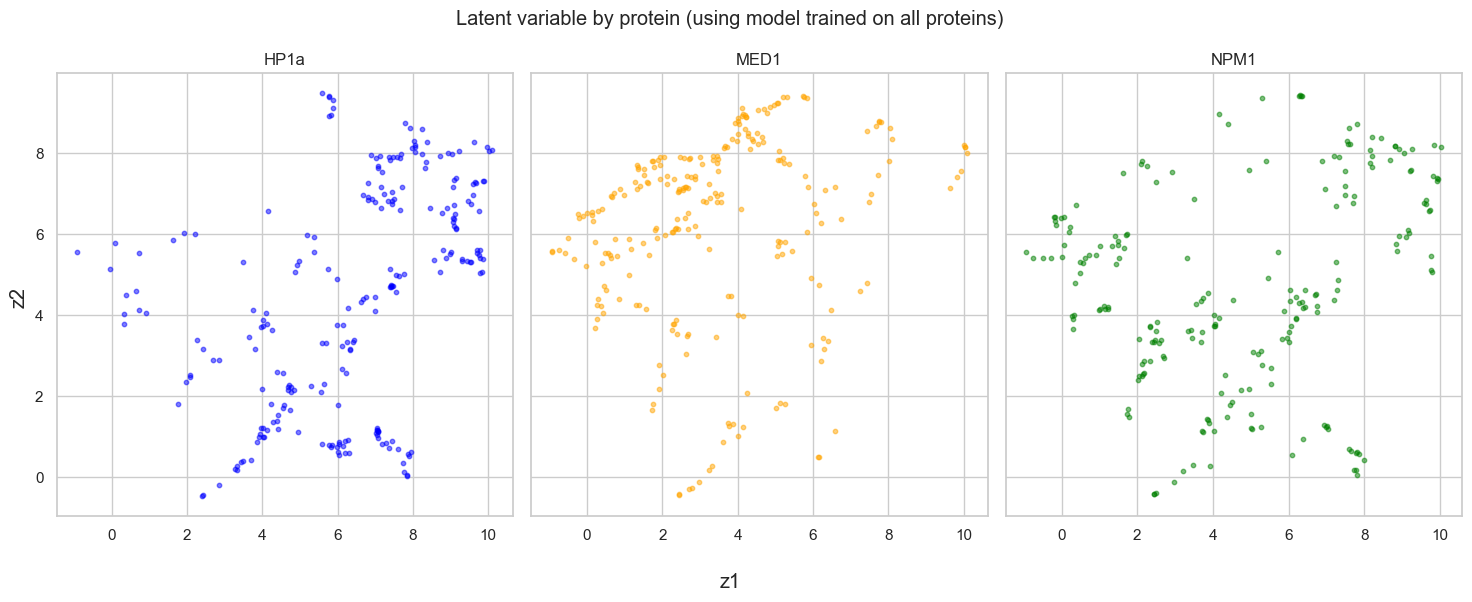

In [4]:
df = pd.read_pickle(os.path.join(DATA_DIR, 'outputs/vae_output_val_clean.csv.pkl'))
df = df.rename(columns={0:'protein'})
df['protein'] = df['protein'].replace(protein_dict)
z_cols = [f'z{i}' for i in range(1, 17)]
df[z_cols] = pd.DataFrame(df['z'].tolist())

distance = 'euclidean'
epoch = 200

reducer = umap.UMAP(verbose=False, n_epochs=epoch, metric=distance, low_memory=True)
sample_df = df.sample(n=700).reset_index(drop=True)
umap_embedding = reducer.fit_transform(sample_df[z_cols].to_numpy())

plot_all_df = pd.concat([pd.DataFrame(umap_embedding), sample_df['protein']], axis=1)

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
fig.suptitle('Latent variable by protein (using model trained on all proteins)')
fig.supxlabel('z1')
fig.supylabel('z2')

df_plot = plot_all_df[plot_all_df['protein'] == 'hp1a']
axes[0].scatter(x=df_plot[0], y=df_plot[1], s=10, alpha=0.5, color='blue')
axes[0].set_title('HP1a')

df_plot = plot_all_df[plot_all_df['protein'] == 'med1']
axes[1].scatter(x=df_plot[0], y=df_plot[1], s=10, alpha=0.5, color='orange')
axes[1].set_title('MED1')

df_plot = plot_all_df[plot_all_df['protein'] == 'npm1']
axes[2].scatter(x=df_plot[0], y=df_plot[1], s=10, alpha=0.5, color='green')
axes[2].set_title('NPM1')

plt.tight_layout()
plt.savefig('latent_all_dim16.png', dpi=300)
plt.show()

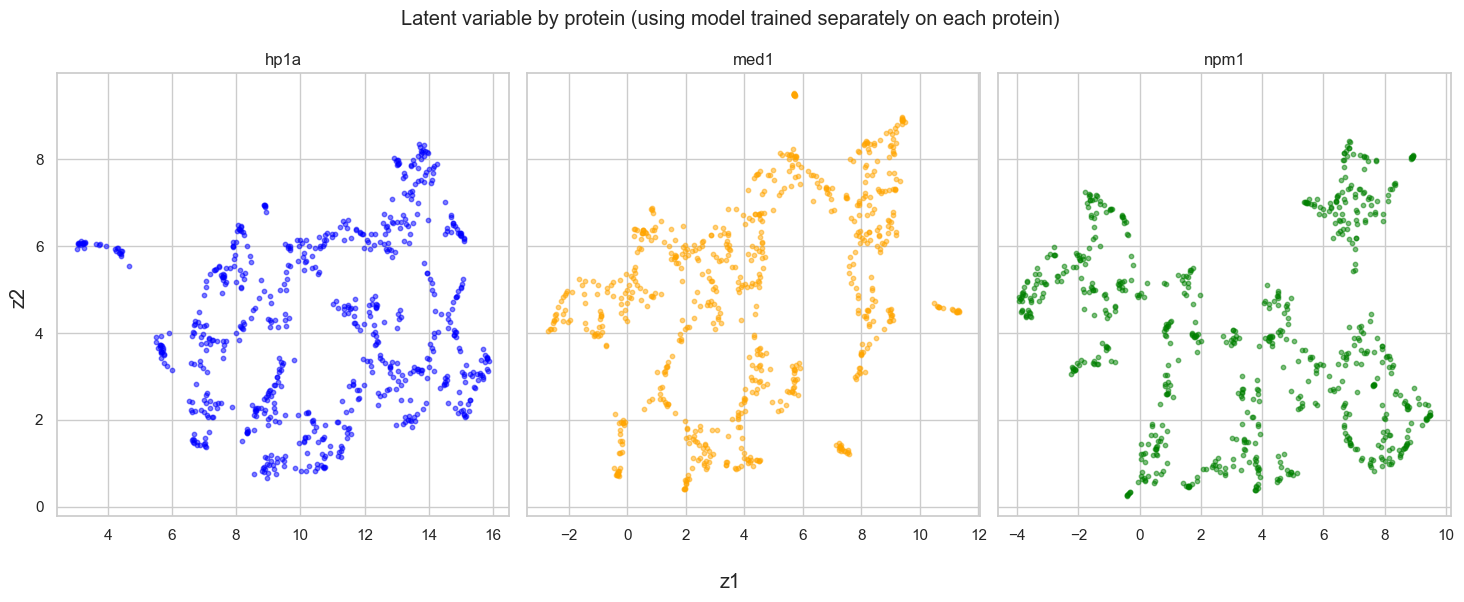

In [5]:
plot_all_df = pd.concat([pd.DataFrame(umap_embedding), sample_df['protein']], axis=1)

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
fig.supxlabel('z1')
fig.supylabel('z2')

color_dict = {0:'blue',
              1:'orange',
              2:'green'
             }

for i in range(3):
    protein = protein_dict[i]
    df = pd.read_pickle(os.path.join(DATA_DIR, f'outputs/vae_output_val_{protein}_clean.csv.pkl'))
    df = df.rename(columns={0:'protein'})
    z_cols = [f'z{i}' for i in range(1, 17)]
    df[z_cols] = pd.DataFrame(df['z'].tolist())

    distance = 'euclidean'
    epoch = 200

    reducer = umap.UMAP(verbose=False, n_epochs=epoch, metric=distance, low_memory=True)
    sample_df = df.sample(n=700).reset_index(drop=True)
    umap_embedding = reducer.fit_transform(sample_df[z_cols].to_numpy())
    
    plot_all_df = pd.concat([pd.DataFrame(umap_embedding), sample_df['protein']], axis=1)
    
    axes[i].scatter(x=plot_all_df[0], y=plot_all_df[1], s=10, alpha=0.5, color=color_dict[i])
    axes[i].set_title(protein)

fig.suptitle('Latent variable by protein (using model trained separately on each protein)')
plt.tight_layout()
plt.savefig(f'latent_sep_dim16.png', dpi=300)
plt.show()